# Prediction model

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

## Import data
Might still need to clean up the files some after import

In [3]:
path = '../Clean Data'
X_fn = 'X.csv'
y_fn = 'y.csv'
X_path = os.path.join(path, X_fn)
y_path = os.path.join(path, y_fn)

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [8]:
X.head()

,Unnamed: 0,cluster_id_6,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),Month,NG Price ($/mcf),All coal,Lignite,Subbituminous
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,1,6.42,25.1475,20.0275,28.115
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,1,6.42,25.1475,20.0275,28.115
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,1,6.42,25.1475,20.0275,28.115
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,1,6.42,25.1475,20.0275,28.115
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,1,6.42,25.1475,20.0275,28.115


Rename the cluster column to just `cluster`. This won't be needed once we export from the group classification with the correct column name

In [9]:
X.rename(columns={'cluster_id_6':'cluster'}, inplace=True)

### One-hot encoding of the cluster variable
I'm trying to make this easy for using with different numbers of clusters

In [10]:
cluster_ids = X['cluster'].unique()
for cluster in cluster_ids:
    X['cluster_{}'.format(cluster)] = np.eye(len(cluster_ids))[X['cluster'],cluster]

In [11]:
X.head()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,NG Price ($/mcf),All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.tail()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,NG Price ($/mcf),All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
473329,473329,5,2015,11476.0,2015-12-31 19:00:00,7516.0,39908.77734,16170.0,3824.932373,23.654498,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473330,473330,5,2015,11476.0,2015-12-31 20:00:00,6552.0,38736.85938,16170.0,4625.632813,28.606264,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473331,473331,5,2015,11476.0,2015-12-31 21:00:00,5944.0,37587.70313,16170.0,4957.714844,30.659956,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473332,473332,5,2015,11476.0,2015-12-31 22:00:00,5698.0,36356.26172,16170.0,4699.097656,29.060592,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473333,473333,5,2015,11476.0,2015-12-31 23:00:00,5365.0,35150.33984,16170.0,4313.125000,26.673624,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
y.tail()

,Unnamed: 0,DATETIME,cluster_id_6,Gen Change (MW)
473329,473329,2015-12-31 19:00:00,5,-20.0
473330,473330,2015-12-31 20:00:00,5,-964.0
473331,473331,2015-12-31 21:00:00,5,-608.0
473332,473332,2015-12-31 22:00:00,5,-246.0
473333,473333,2015-12-31 23:00:00,5,-333.0


### Drop unnecessary columns and replace nan's with 0

In [14]:
X_cols = ['nameplate_capacity', 'GROSS LOAD (MW)', 'ERCOT Load, MW',
          'Total Wind Installed, MW', 'Total Wind Output, MW', 'Net Load Change (MW)',
          'NG Price ($/mcf)', 'All coal', 'Lignite', 'Subbituminous']
X_cluster_cols = ['cluster_{}'.format(cluster) for cluster in cluster_ids]

X_clean = X.loc[:,X_cols+X_cluster_cols]
X_clean.fillna(0, inplace=True)

y_clean = y.loc[:,'Gen Change (MW)']
y_clean.fillna(0, inplace=True)

In [15]:
print X_clean.shape
print y_clean.shape

(473334, 16)
(473334,)


### Split into training, validation, testing

In [16]:
X_train = X_clean.loc[(X['Year']<2012),:]
y_train = y_clean.loc[(X['Year']<2012)]

X_va = X_clean.loc[X['Year'].isin([2012, 2013]),:]
y_va = y_clean.loc[X['Year'].isin([2012, 2013])]

X_test = X_clean.loc[X['Year']>2013,:]
y_test = y_clean.loc[X['Year']>2013]

**Somehow we're missing 2 records from X_va**

In [17]:
print X_va.shape, y_va.shape

(105264, 16) (105264,)


Need scaled versions of the X data for some of the models

In [20]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_va_scaled = StandardScaler().fit_transform(X_va)
X_test_scaled = StandardScaler().fit_transform(X_test)

Check size of all arrays

In [21]:
print X_train_scaled.shape, y_train.shape
print X_va_scaled.shape, y_va.shape
print X_test_scaled.shape, y_test.shape

(262944, 16) (262944,)
(105264, 16) (105264,)
(105126, 16) (105126,)


## Linear Regression (OLS)

In [22]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
lm.score(X_va_scaled, y_va)

0.26493465890853507

In [24]:
y_pr = lm.predict(X_va_scaled)

In [41]:
y_va.values.shape, y_pr.shape, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values.shape

((105266,), (105264,), (105264,))

In [25]:
y_lm_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))
# y_lm_resids['y_pr'] = y_pr
# y_lm_resids['cluster'] = X.loc[:,'cluster']

In [26]:
y_lm_resids.head()

,Gen Change (MW),cluster,y_pr
0,0.0,0,-61.176003
1,1.0,0,-20.166237
2,-1.0,0,-17.027565
3,0.0,0,-14.052956
4,0.0,0,21.281029


In [27]:
y_lm_resids.loc[:,'residuals'] = y_lm_resids.loc[:,'y_pr'] - y_lm_resids.loc[:,'Gen Change (MW)']

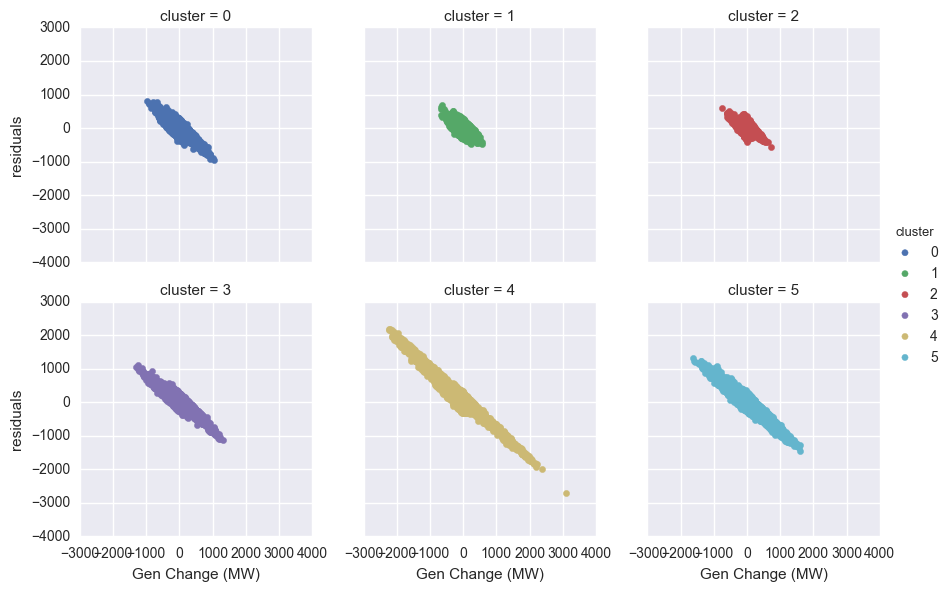

In [29]:
g = sns.FacetGrid(y_lm_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'Gen Change (MW)', 'residuals')
g.add_legend()

## SVR
Shows use with GridSearchCV if you guys want to use it

In [34]:
svm = SVR()

In [35]:
parameters = {'C':np.logspace(-5, 1, num=5)}

In [36]:
lm = GridSearchCV(svm, parameters, n_jobs=-1, verbose=3)

In [ ]:
lm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=0.000316227766017 .............................................
